# ДЗ

>### Relevant Information:
   -- This data file contains details of various nations and their flags.
      In this file the fields are separated by spaces (not commas).  With
      this data you can try things like predicting the religion of a country
      from its size and the colours in its flag.  
   -- 10 attributes are numeric-valued.  The remainder are either Boolean-
      or nominal-valued.
  

1. Загрузить данные из папки Data Folder
1. Провести описательный анализ предложенных данных
1. Предложить стратегию по работе с категориальными переменными
1. Провести углубленный анализ данных (корреляции переменных, визуализация взаимосвязей)
1. Следует ли увеличивать/уменьшать размерность признакового множества (какой подход выдает лучшие результаты)
1. Следует ли балансировать классы путем oversampling/undersampling? (улучшает ли подход результаты)
1. Сделать кросс-валидацию данных с использованием подхода K-fold (n_folds=3)
1. Решить задачу мультиклассовой классификации и предсказать религию страны (religion) по деталям ее флага
1. Рассчитать Feature Importances для переменных модели
1. Проверить качество классификации с использованием следующих метрик: Accuracy, F1-Score, Precision, Recall
1. Построить Confusion Matrix для ваших результатов


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV


In [2]:
columns = str('name  landmass  zone  area  population language   religion  bars stripes colours red green blue gold white black orange mainhue   circles crosses saltires quarters sunstars crescent triangle icon animate  text  topleft  botright ').split()
df = pd.read_csv('flag.data.csv', names=columns  )
df.head(3) 

,name,landmass,zone,area,population,language,religion,bars,stripes,colours,...,saltires,quarters,sunstars,crescent,triangle,icon,animate,text,topleft,botright
0,Afghanistan,5,1,648,16,10,2,0,3,5,...,0,0,1,0,0,1,0,0,black,green
1,Albania,3,1,29,3,6,6,0,0,3,...,0,0,1,0,0,0,1,0,red,red
2,Algeria,4,1,2388,20,8,2,2,0,3,...,0,0,1,1,0,0,0,0,green,white


In [3]:
# 'name' уникальная для каждого флага

#### ДЗ№3. Предложить стратегию по работе с категориальными переменными

Разбить на категории из 2х признаков и из признаков>2

In [4]:
categories = ['landmass','zone','language','red','green','blue','gold','white','black','orange','crescent','triangle','icon','animate','text','mainhue','topleft','botright' ]

In [5]:
numerical = [i for i in columns if i not in categories + ['name', 'religion']]

In [6]:
# отсеем ббиноминальные 
binomin = []
for i in categories:
    if df[i].nunique()==2: binomin.append(i)
' , '.join(binomin)

'red , green , blue , gold , white , black , orange , crescent , triangle , icon , animate , text'

In [7]:
categories = [i for i in categories if i not in binomin ]

#### ДЗ№4. Провести углубленный анализ данных (корреляции переменных, визуализация взаимосвязей)

<AxesSubplot:>

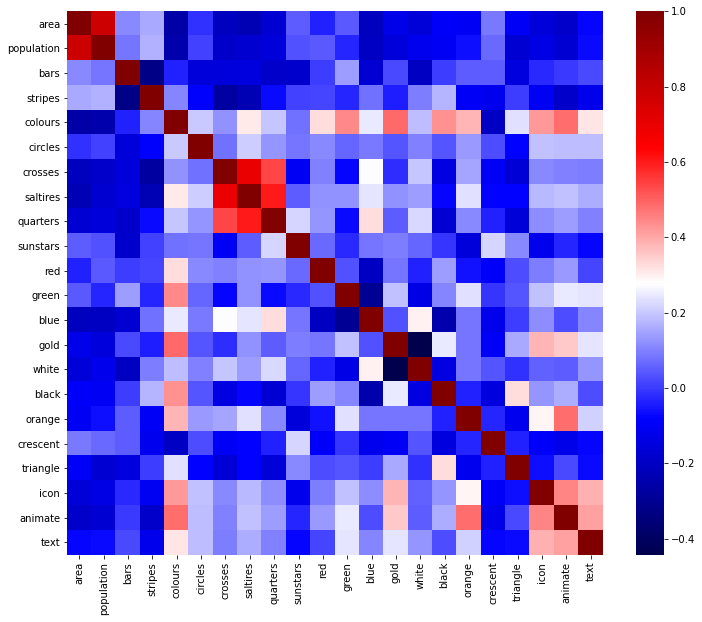

In [8]:
# проведем сравнение коэф корреляции, так как есть категории, то буду использовать метод Спеармана
corr_coeff = df[numerical+binomin].corr(method='spearman' )
plt.figure(figsize=(12,10))
sns.heatmap(corr_coeff, cmap='seismic')

Моно заметить:
- 'area' & 'population' имеют сильную корреляцию, будет полезно исключить один из признаков, например 'area' так как population - сразу понятно о чем идет речь
- 'crosses' & 'saltires' имеют сильную корреляцию, будет полезно исключить один из признаков, например 'saltires' так как crosses - сразу понятно о чем идет речь и 'qualters' тоже сильно коррелирует с  'saltires'. Одним выстрелом убъем 2х зайцев.
- Еще очень сильно коррелируют 'animate' или 'colours' можно убрать один из них, но потом, на финальном сравнении.

In [9]:
df.drop( columns=['area','saltires'],inplace=True)


#### ДЗ№5.  Следует ли увеличивать/уменьшать размерность признакового множества (какой подход выдает лучшие результаты)

In [10]:
df.shape

(194, 28)

объектов катастрофически мало, нужен бутстрап. 
1. соберем финальный датасет 
1. разобъем на треин тест
1. создадим бутстрэп


#### ДЗ№6.  Следует ли балансировать классы путем oversampling/undersampling? (улучшает ли подход результаты)

religion
0    40
1    60
2    36
3     8
4     4
5    27
6    15
7     4
Name: name, dtype: int64


<BarContainer object of 8 artists>

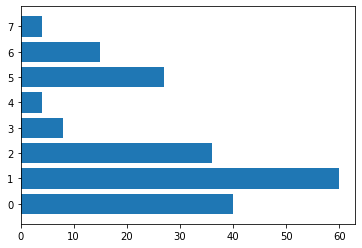

In [11]:
# проверим распределение по классам:
classes = df.groupby(by='religion').name.count()
print(classes)
plt.barh(y = range(len(set(df.religion))),  width=classes )

Классы не сбалансированны. Добавим bootstraps в классы 3,4,5,6,7 до количества 30шт. 

In [12]:
classes = dict(classes)
missed_classes = [3,4,5,6,7]

for i in missed_classes:
    classes_index = df[df.religion==i].index

    samples = 30 - classes[i]

    random_samples = np.random.choice(classes_index, samples, replace=True )
    df = pd.concat( (df, df.loc[random_samples,:]),axis=0)

religion
0    40
1    60
2    36
3    30
4    30
5    30
6    30
7    30
Name: name, dtype: int64


<BarContainer object of 8 artists>

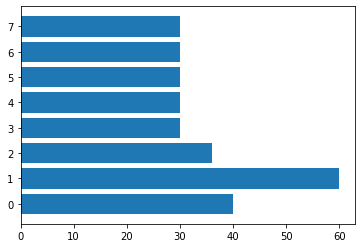

In [13]:
# заново проверим распределение по классам:
new_classes = df.groupby(by='religion').name.count()
print(new_classes)
plt.barh(y = range(len(set(df.religion))),  width=new_classes )

In [14]:
df = df.reset_index().drop(columns='index')

#### ДЗ№7.  Сделать кросс-валидацию данных с использованием подхода K-fold (n_folds=3)
#### ДЗ№8.  Решить задачу мультиклассовой классификации и предсказать религию страны (religion) по деталям ее флага
#### ДЗ№9.  Рассчитать Feature Importances для переменных модели

выполним все по порядку, сначала подготовим датасет.
1. уберем и закодируем бинарные классы
1. сделаем дамми из классов
1. создадим финальный датасет
1. Сделаем бутстрэп до 5000 значений.
1. Разобъем на трейн тест
1. Создадим RandomForest, Bagging (на DecisionTreeClassifiers) или Logit  так как они умеют показывать значимость признаков. 
1. Создадим K-fold cross val score по указанным алгоритмам
1. Выберем самый лучший алгоритм по score
1. вытащим feature importances из алгоритма

##### уберем и закодируем бинарные классы

In [15]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [16]:
categories = [i for i in categories if i not in ['religion']]
numerical = [i for i in numerical if i not in ['religion']]

In [17]:
dummy_binary = pd.DataFrame({i:le.fit_transform( df[i] ) for i in binomin } )
dummy_binary_descr = {i:(le.fit( df[i] ).classes_) for i in binomin }

##### сделаем дамми из классов

In [18]:
# Создаем дамми:
dummy = pd.get_dummies(df[categories], columns=categories)

##### создадим финальный датасет

In [19]:
numerical = [i for i in numerical if i not in ['saltires', 'area']]

In [20]:
X = pd.concat( (df[numerical], dummy_binary , dummy ),axis=1  )

In [21]:
y = df.religion

##### Сделаем бутстрэп до 2000 значений.

In [22]:
samples = 2000

random_samples = np.random.choice(list(X.index), samples, replace=True )
X = X.loc[random_samples,:]
y = y[random_samples]

##### Разобъем на трейн тест

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3)

In [24]:
# Нормализируем
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

#### Создадим RandomForest, Bagging (на DecisionTreeClassifiers) или Logit так как они умеют показывать значимость признаков. 

In [25]:
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

In [26]:

algoritms = [
    {'name': 'RandFrst' , 'model': RandomForestClassifier(n_jobs=-1)   , 'params': {'n_estimators':list(range(100,500,1)),'criterion': ["gini", "entropy"],'max_depth':list(range(5,100))+[None],'ccp_alpha':np.arange(.1,2,.1)     }},
    {'name': 'BagTree' , 'model': BaggingClassifier(n_jobs=-1)   , 'params': { 'base_estimator':[RandomForestClassifier(),DecisionTreeClassifier()],'n_estimators':list(range(3,23)) }},
    {'name': 'BagLogit' , 'model': BaggingClassifier(n_jobs=-1)   , 'params': { 'base_estimator':[LogisticRegression(solver='saga',penalty = 'elasticnet',n_jobs=-1,l1_ratio=.5) ],'n_estimators':list(range(3,23)) }},
    {'name': 'Logit' , 'model': LogisticRegression(solver='saga',penalty = 'elasticnet',n_jobs=-1,max_iter=1000)   , 'params': { 'multi_class':['ovr', 'multinomial'],'C':np.arange(0,5,.2),'max_iter':list(range(100,500)), 'l1_ratio':list(np.arange(0,1.01,.01)) }},
]

In [ ]:
results = []

for algo in algoritms:
    results.append((  algo['name'],  RandomizedSearchCV(algo['model'],algo['params'], cv=4 ).fit(X_train_scaled,y_train)    ))

In [30]:
for result in results:
    print(result[0], result[1].best_score_, result[1].best_params_)

RandFrst 0.7978571428571429 {'n_estimators': 157, 'max_depth': 52, 'criterion': 'entropy', 'ccp_alpha': 0.1}
BagTree 0.9985714285714286 {'n_estimators': 11, 'base_estimator': DecisionTreeClassifier()}
BagLogit 0.9892857142857143 {'n_estimators': 19, 'base_estimator': LogisticRegression(l1_ratio=0.5, n_jobs=-1, penalty='elasticnet', solver='saga')}
Logit 0.9978571428571429 {'multi_class': 'multinomial', 'max_iter': 320, 'l1_ratio': 0.64, 'C': 4.4}


Хоть проводили и RandomiedSearcCV, думаю что результат на GridSearchCV, будет таким же.  

Лучший алгоритм: 

In [46]:
best_algoritm = results[3][1].best_estimator_

In [50]:
results[3][1].best_estimator_.

LogisticRegression(C=4.4, l1_ratio=0.64, max_iter=320,
                   multi_class='multinomial', n_jobs=-1, penalty='elasticnet',
                   solver='saga')

#### ДЗ№10.  Рассчитать Feature Importances для переменных модели

In [55]:
religion_columns = ['Catholic','Other Christian', 'Muslim', 'Buddhist', 'Hindu','Ethnic', 'Marxist', 'Others'] 

In [78]:
features = pd.DataFrame(data=best_algoritm.coef_,index=religion_columns, columns=X_train.columns)

In [70]:
best_features= []
for i in features.index:
    a= features.loc[i,:].sort_values(ascending=False).head(10)
    best_features.append((i,a))

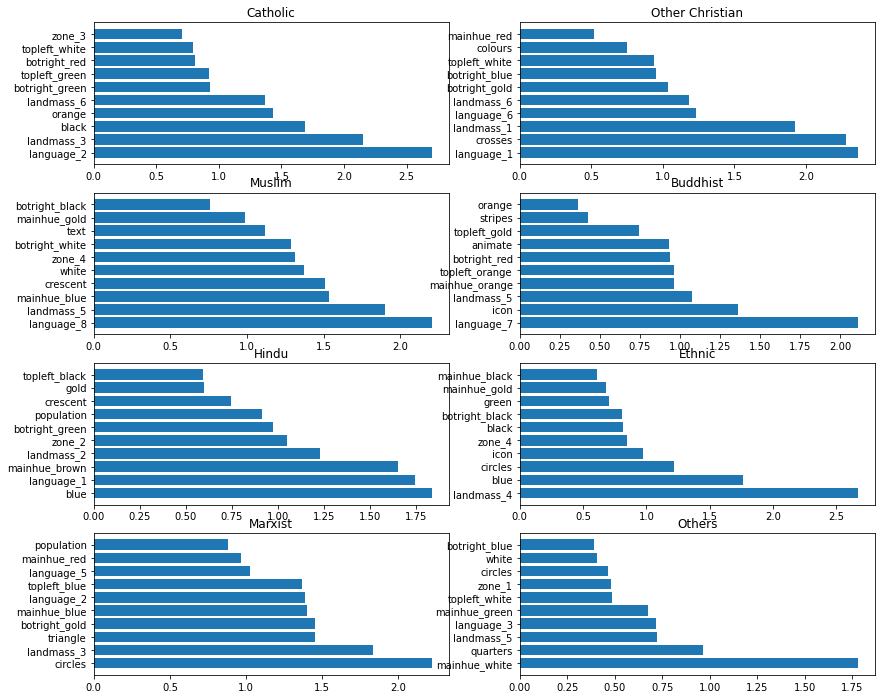

In [77]:
fig = plt.figure(figsize=(14,12))
for i in range(8):
    fig.add_subplot(421+i)
    plt.barh(y=range(10),width=best_features[i][1],tick_label=best_features[i][1].index  )
    plt.title(best_features[i][0])

#### ДЗ№11.  Проверить качество классификации с использованием следующих метрик: Accuracy, F1-Score, Precision, Recall

In [80]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [89]:
y_pred = best_algoritm.predict(X_test_scaled)
acc_score = accuracy_score(y_test,y_pred)
f1 = f1_score(y_test,y_pred,average='macro')
precision = precision_score(y_test,y_pred,average='macro')
recall = recall_score(y_test,y_pred,average='micro')
print(f'accuracy_score = {acc_score},f1_score = {f1},precision_score = {precision},  recall_score = {recall}')

accuracy_score = 1.0,f1_score = 1.0,precision_score = 1.0,  recall_score = 1.0


#### ДЗ№12.  Построить Confusion Matrix для ваших результатов

In [91]:
from sklearn.metrics import confusion_matrix

In [92]:
confusion_matrix(y_test,y_pred)

array([[ 79,   0,   0,   0,   0,   0,   0,   0],
       [  0, 128,   0,   0,   0,   0,   0,   0],
       [  0,   0,  73,   0,   0,   0,   0,   0],
       [  0,   0,   0,  64,   0,   0,   0,   0],
       [  0,   0,   0,   0,  56,   0,   0,   0],
       [  0,   0,   0,   0,   0,  74,   0,   0],
       [  0,   0,   0,   0,   0,   0,  70,   0],
       [  0,   0,   0,   0,   0,   0,   0,  56]], dtype=int64)